In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from data.dataset import DataSet
from data.transform import BaseTransform
from data.sampler import TripletSampler, InferenceSampler
from models.baseline import Baseline
import matplotlib.pyplot as plt

In [2]:
model = Baseline()
# Baseline.run_train(model)

RuntimeError: Error(s) in loading state_dict for Baseline:
	size mismatch for FCs.fc_bin: copying a param with shape torch.Size([31, 256, 128]) from checkpoint, the shape in current model is torch.Size([15, 256, 128]).
	size mismatch for BNNecks.fc_bin: copying a param with shape torch.Size([31, 128, 43]) from checkpoint, the shape in current model is torch.Size([15, 128, 43]).
	size mismatch for BNNecks.bn1d.weight: copying a param with shape torch.Size([3968]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for BNNecks.bn1d.bias: copying a param with shape torch.Size([3968]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for BNNecks.bn1d.running_mean: copying a param with shape torch.Size([3968]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for BNNecks.bn1d.running_var: copying a param with shape torch.Size([3968]) from checkpoint, the shape in current model is torch.Size([1920]).

Transforming: 100%|██████████| 12630/12630 [00:04<00:00, 3059.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


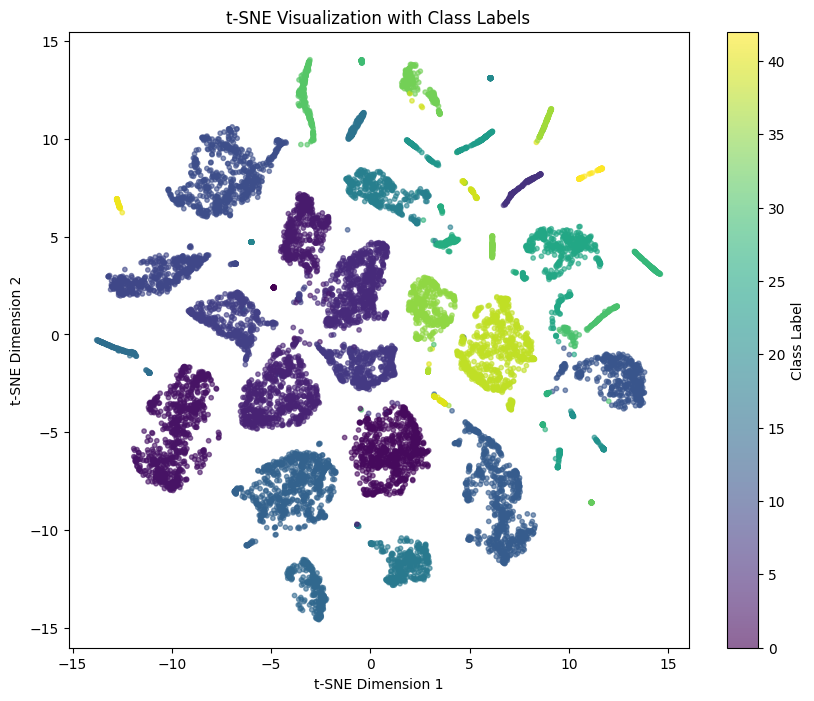

In [ ]:
features = model.inference()

labels = features['labels']
features = features['embeddings']

from sklearn.manifold import TSNE

features_flat = features.reshape(features.shape[0], -1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features_flat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, s=10, alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Transforming: 100%|██████████| 39209/39209 [00:08<00:00, 4406.68it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


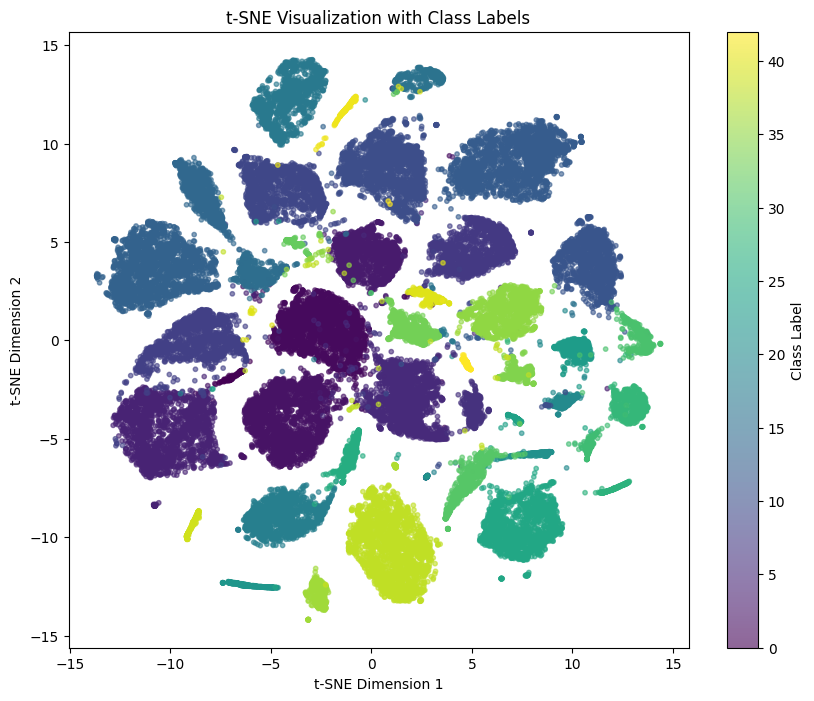

In [ ]:
features = model.inference(model.train2_loader)

labels = features['labels']
features = features['embeddings']

from sklearn.manifold import TSNE

features_flat = features.reshape(features.shape[0], -1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features_flat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, s=10, alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
from evaluation.re_rank import re_ranking
from evaluation.metric import cuda_dist

feat = features
dist = cuda_dist(feat, feat).cpu().numpy()

In [ ]:
optimized_dist = re_ranking(dist, k1=6, k2=6, lambda_value=0.3)

In [ ]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(metric='precomputed', eps=1, min_samples=5)
pseudo_labels = clusterer.fit_predict(optimized_dist)

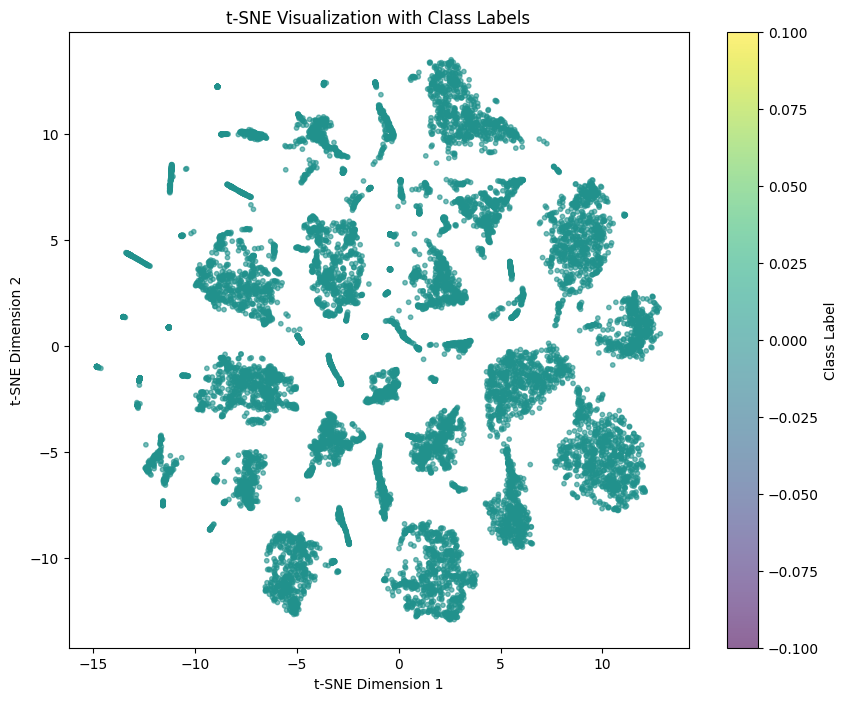

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=pseudo_labels, s=10, alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE Visualization with Class Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
model.test_dataset[2][1]

np.int64(38)

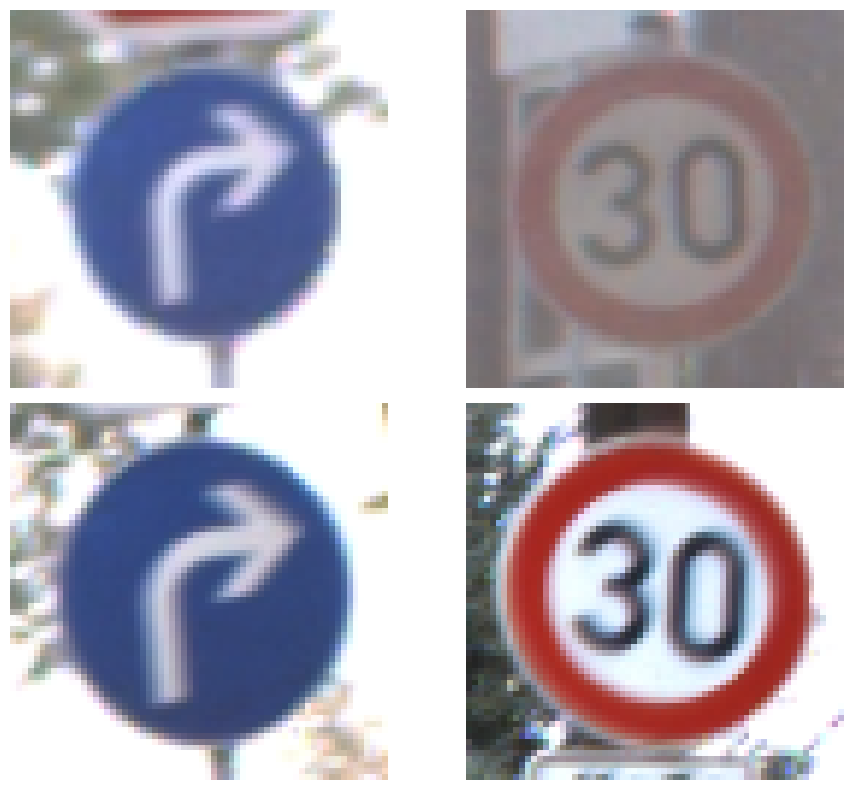

In [ ]:
csv_path ='datasets/GTSRB/Train.csv'
root_dir ='datasets/GTSRB'
from torchvision.transforms import Compose
transform = Compose([
    BaseTransform(),
])

dataset = DataSet(
    csv_path=csv_path,
    root_dir=root_dir,
)
sampler = TripletSampler(
    dataset=dataset,
    batch_shuffle=True,
    batch_size=(2, 2)
)
import torch.utils.data as tordata
loader = tordata.DataLoader(
    dataset=dataset,
    batch_sampler=sampler,
    num_workers=1
)

import matplotlib.pyplot as plt

batch = next(iter(loader))
def show_batch(batch, nrows=2, ncols=2):
    plt.figure(figsize=(10, 8))
    
    # 转换为NHWC格式并取前nrows*ncols张
    # batch = transform(batch)  
    images = batch[:nrows*ncols].permute(0, 2, 3, 1).cpu().numpy()
    
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# 执行可视化
show_batch(batch[0], nrows=2, ncols=2)